In [1]:
import tensorflow as tf
from tensorflow.keras import regularizers
gpu = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Available: ", len(gpu))
tf.config.experimental.set_memory_growth(gpu[0], True)
import os
from numba import jit
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input
from keras import applications
from keras import layers
from keras import models
from keras import utils
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2
from cv2 import dnn_superres
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback
wandb.login()
import random

GPUs Available:  1


ModuleNotFoundError: No module named 'numba'

: 

In [2]:
%%time
inputTensor = Input(shape= (32,32,3))
#up2d = layers.UpSampling2D((7,7))(inputTensor)
res = 32
imgnet = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (res, res, 3))#, input_tensor = up2d)
imgnet.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [3]:
%%time
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_test.shape

CPU times: total: 594 ms
Wall time: 599 ms


(10000, 1)

In [4]:
%%time
y_train = to_categorical(y_train, dtype='int')
y_test = to_categorical(y_test, dtype='int')
y_test.shape

#x_train = x_train.astype('float32') / 255
#x_test = x_test.astype('float32') / 255

CPU times: total: 0 ns
Wall time: 966 µs


(10000, 10)

In [5]:
#%%time
#train_size = 25000
#test_size = 5000
#X_train = X_train[-train_size:]
#y_train = y_train[-train_size:]

#X_test = X_test[-test_size:]
#y_test = y_test[-test_size:]
#X_train.shape

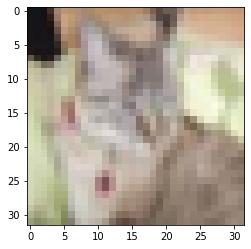

In [6]:
#%%time
#sr = cv2.dnn_superres.DnnSuperResImpl_create()
#path = "EDSR_x4.pb"
#sr.readModel(path)
#sr.setModel("edsr",4)
#x_train = np.ndarray([train_size, res, res, 3])
#x_test = np.ndarray([test_size, res, res, 3])
#print("start")

#for i in range(0,test_size):
    #print(i)
#    x_test[i] = sr.upsample(X_test[i])
#    x_train[i] = sr.upsample(X_train[i])
#    x_test[i] = cv2.resize(X_test[i],(res,res),interpolation = cv2.INTER_CUBIC)
#    x_train[i] = cv2.resize(X_train[i],(res,res),interpolation = cv2.INTER_CUBIC)
#print("1/6")
#for i in range(test_size,train_size):
    #print(i)
#    x_train[i] = sr.upsample(X_train[i])
    #x_train[i] = cv2.resize(X_train[i],(res,res),interpolation = cv2.INTER_CUBIC)
#print("finish")

#np.save('x_train', x_train)
#np.save('x_test', x_test)
#x_train = np.load('x_train.npy')
#x_test = np.load('x_test.npy')
plt.imshow(x_test[8].astype(int))


In [7]:
wandb.init(
    # set the wandb project where this run will be logged
    project="wandb-test",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 512,
        "activation_1": "relu",
        "dropout": 0.4,
        "layer_2": 10,
        "activation_2": "softmax",
        "optimizer": "optimizers.Adam(learning_rate = 0.000001)",
        "loss": "categorical_crossentropy",
        "metric": "accuracy",
        "epoch": 15,
        "batch_size": 128
    }
)
sweep_config = {
    'method' : 'grid'
}
metric = {
    'name' : 'val_accuracy',
    'goal' : 'maximize'
}
sweep_config['metric'] = metric
parameters_dict = {
    'optimizer' : {
        'values' : ['adam','sgd']
    },
    'layer_1' :{
        'values' : [32,64,128,256,512]
    },
    'batch_size' : {
        'values' : [16,32,64,128,256]
    },
    'dropout' : {
        'values' : [0.2,0.5,0.8]
    },
    'activation_1' : {
        'values' : ['softmax', 'relu']
    },
    'activation_2' : {
        'values' : ['softmax', 'relu']
    },
    
}
sweep_config['parameters'] = parameters_dict
sweep_id = wandb.sweep(sweep_config, project = "wandb-test")
config = wandb.config

Create sweep with ID: 8aesnhoo
Sweep URL: https://wandb.ai/ai-research-unifesp/wandb-test/sweeps/8aesnhoo


In [8]:
sweep_id

'8aesnhoo'

In [9]:
def model(layer_1, activation_1, dropout, activation_2, optimizer, Loss):
    new = models.Sequential(imgnet.layers[:11])
        
    for layer in new.layers:
        layer.trainable = False

    #new.add(layers.GlobalAveragePooling2D())
    new.add(layers.Flatten())

    new.add(layers.BatchNormalization())
    new.add(layers.Dense(layer_1, activation=activation_1))#, activity_regularizer=regularizers.L2(1e-6)))
    new.add(layers.Dropout(dropout))
    
    new.add(layers.Dense(10, activation = activation_2))

    new.compile(optimizer = optimizers.Adam(learning_rate = 0.0008), loss = Loss, metrics = ['accuracy'])
    return new
new = model(config.layer_1, config.activation_1, config.dropout, config.activation_2, config.optimizer, config.loss)
new.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)         2

In [10]:
checkpoint_path = "./training/cp-{epoch:02d}-{val_accuracy:.5f}.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = ModelCheckpoint(checkpoint_path, monitor = "val_accuracy", save_best_only = True, save_freq="epoch", mode = "max")
sstop = EarlyStopping(monitor = 'val_loss', patience = 1) 

In [11]:
import pprint
pprint.pprint(sweep_config)


{'method': 'grid',
 'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
 'parameters': {'activation_1': {'values': ['softmax', 'relu']},
                'activation_2': {'values': ['softmax', 'relu']},
                'batch_size': {'values': [16, 32, 64, 128, 256]},
                'dropout': {'values': [0.2, 0.5, 0.8]},
                'layer_1': {'values': [32, 64, 128, 256, 512]},
                'optimizer': {'values': ['adam', 'sgd']}}}


In [12]:
%%time
new.fit(x_train, y_train, epochs= 30, validation_split=0.2, batch_size= 256, callbacks=[checkpoint, WandbCallback()], shuffle = True)
wandb.log({'val_acc': 'val_accuracy'})

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/30
157/157 [==============================] - ETA: 0s - loss: 1.1234 - accuracy: 0.6780

INFO:tensorflow:Assets written to: c:\Users\mathe\IC (Machine Learning)\wandb\run-20230309_101455-1u5t6qa0\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\mathe\IC (Machine Learning)\wandb\run-20230309_101455-1u5t6qa0\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\mathe\IC (Machine Learning)\wandb\run-20230309_101455-1u5t6qa0\files\model-best)... Done. 0.1s


157/157 [==============================] - 8s 38ms/step - loss: 1.1234 - accuracy: 0.6780 - val_loss: 0.7406 - val_accuracy: 0.7688
Epoch 2/30
155/157 [============================>.] - ETA: 0s - loss: 0.6170 - accuracy: 0.7926

INFO:tensorflow:Assets written to: c:\Users\mathe\IC (Machine Learning)\wandb\run-20230309_101455-1u5t6qa0\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\mathe\IC (Machine Learning)\wandb\run-20230309_101455-1u5t6qa0\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\mathe\IC (Machine Learning)\wandb\run-20230309_101455-1u5t6qa0\files\model-best)... Done. 0.1s


157/157 [==============================] - 6s 36ms/step - loss: 0.6166 - accuracy: 0.7926 - val_loss: 0.6035 - val_accuracy: 0.7988
Epoch 3/30
153/157 [============================>.] - ETA: 0s - loss: 0.4623 - accuracy: 0.8400

INFO:tensorflow:Assets written to: c:\Users\mathe\IC (Machine Learning)\wandb\run-20230309_101455-1u5t6qa0\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\mathe\IC (Machine Learning)\wandb\run-20230309_101455-1u5t6qa0\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\mathe\IC (Machine Learning)\wandb\run-20230309_101455-1u5t6qa0\files\model-best)... Done. 0.1s


157/157 [==============================] - 5s 29ms/step - loss: 0.4634 - accuracy: 0.8396 - val_loss: 0.5837 - val_accuracy: 0.8058
Epoch 4/30
156/157 [============================>.] - ETA: 0s - loss: 0.3758 - accuracy: 0.8681

INFO:tensorflow:Assets written to: c:\Users\mathe\IC (Machine Learning)\wandb\run-20230309_101455-1u5t6qa0\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\mathe\IC (Machine Learning)\wandb\run-20230309_101455-1u5t6qa0\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\mathe\IC (Machine Learning)\wandb\run-20230309_101455-1u5t6qa0\files\model-best)... Done. 0.1s


157/157 [==============================] - 5s 30ms/step - loss: 0.3758 - accuracy: 0.8681 - val_loss: 0.5662 - val_accuracy: 0.8174
Epoch 5/30
153/157 [============================>.] - ETA: 0s - loss: 0.3014 - accuracy: 0.8935

INFO:tensorflow:Assets written to: c:\Users\mathe\IC (Machine Learning)\wandb\run-20230309_101455-1u5t6qa0\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\mathe\IC (Machine Learning)\wandb\run-20230309_101455-1u5t6qa0\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\mathe\IC (Machine Learning)\wandb\run-20230309_101455-1u5t6qa0\files\model-best)... Done. 0.1s


157/157 [==============================] - 5s 34ms/step - loss: 0.3016 - accuracy: 0.8935 - val_loss: 0.5613 - val_accuracy: 0.8240
Epoch 6/30
157/157 [==============================] - 3s 17ms/step - loss: 0.2543 - accuracy: 0.9111 - val_loss: 0.5618 - val_accuracy: 0.8250
Epoch 7/30
157/157 [==============================] - 3s 18ms/step - loss: 0.2181 - accuracy: 0.9229 - val_loss: 0.5801 - val_accuracy: 0.8254
Epoch 8/30
157/157 [==============================] - 3s 17ms/step - loss: 0.1941 - accuracy: 0.9311 - val_loss: 0.6134 - val_accuracy: 0.8207
Epoch 9/30
157/157 [==============================] - 3s 18ms/step - loss: 0.1708 - accuracy: 0.9407 - val_loss: 0.5980 - val_accuracy: 0.8245
Epoch 10/30
157/157 [==============================] - 3s 19ms/step - loss: 0.1486 - accuracy: 0.9469 - val_loss: 0.6271 - val_accuracy: 0.8290
Epoch 11/30
157/157 [==============================] - 3s 18ms/step - loss: 0.1396 - accuracy: 0.9506 - val_loss: 0.6496 - val_accuracy: 0.8236
Epoch 12

In [13]:
y_test.shape

(10000, 10)

In [14]:
new.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.9819 - accuracy: 0.8180


[0.9819386601448059, 0.8180000185966492]

In [15]:
%%time
new.trainable = True
new.compile(optimizer = optimizers.RMSprop(learning_rate = 0.00001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
checkpoint_path = "./training/cpFT-{epoch:02d}-{val_accuracy:.5f}.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = ModelCheckpoint(checkpoint_path, monitor = "val_accuracy", save_best_only = True, save_freq="epoch", mode = "max")

new.fit(x_train, y_train, epochs=3, validation_split=0.2, batch_size=256, shuffle = True, callbacks=[checkpoint, WandbCallback()])

Epoch 1/3
157/157 [==============================] - 9s 44ms/step - loss: 0.0516 - accuracy: 0.9819 - val_loss: 0.8770 - val_accuracy: 0.8290
Epoch 2/3
157/157 [==============================] - 7s 44ms/step - loss: 0.0420 - accuracy: 0.9855 - val_loss: 0.8550 - val_accuracy: 0.8318
Epoch 3/3
157/157 [==============================] - 6s 40ms/step - loss: 0.0374 - accuracy: 0.9870 - val_loss: 0.8741 - val_accuracy: 0.8297
CPU times: total: 21.4 s
Wall time: 22.3 s


In [16]:
new.evaluate(x_test, y_test)
new.save('./models/CIFARUpscaled.h5')

313/313 [==============================] - 1s 5ms/step - loss: 0.9346 - accuracy: 0.8236


1/1 [==============================] - 0s 175ms/step
[[5.6961319e-24 2.3574124e-12 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.3789735e-36 0.0000000e+00 0.0000000e+00 5.9949638e-31 1.0000000e+00]]
CPU times: total: 234 ms
Wall time: 223 ms


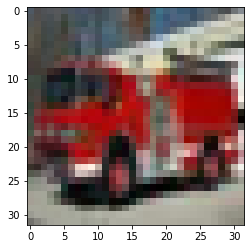

In [17]:
%%time
num = 23
plt.imshow(x_test[num], cmap='gray')
y_test[num]
img = x_test[num]
img = (np.expand_dims(img,0))
predicao = new.predict(img)
print(predicao)

In [18]:
wandb.init(project='wandb-test')
wandb.agent(sweep_id, function = model, count=10)


accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇█▇███████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███▁▁▁
loss,█▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███
val_loss,▅▂▁▁▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇█▇█▇▇▇
accuracy,0.987
best_epoch,4
best_val_loss,0.56132
epoch,2
loss,0.03737
val_acc,val_accuracy


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: 8cdl2goq with config:
wandb: 	activation_1: softmax
wandb: 	activation_2: softmax
wandb: 	batch_size: 16
wandb: 	dropout: 0.2
wandb: 	layer_1: 32
wandb: 	optimizer: adam
Exception in thread Thread-70 (_run_job):
Traceback (most recent call last):
  File "c:\Users\mathe\AppData\Local\Programs\Python\Python310\lib\site-packages\wandb\agents\pyagent.py", line 298, in _run_job
    self._function()
TypeError: model() missing 6 required positional arguments: 'layer_1', 'activation_1', 'dropout', 'activation_2', 'optimizer', and 'Loss'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\mathe\AppData\Local\Programs\Python\Python310\lib\threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "c:\Users\mathe\AppData\Local\Programs\Python\Python310\lib\threading.py", line 946, in run
    self._target(*self._args, **sel